In [ ]:
import pandas as pd
import numpy as np
import torch
import transformers
import datasets
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm

### Load data

In [ ]:
df = pd.read_csv("./drive/MyDrive/ko-cover-letter-ai/jobkorea_preprocessed_answer_good_advice.csv")

In [ ]:
from transformers import PreTrainedTokenizerFast
tokenizer = PreTrainedTokenizerFast.from_pretrained("gogamza/kobart-base-v2")

loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--gogamza--kobart-base-v2/snapshots/d9a1f640896cef8dcfd693b1bc57510a2b09a18f/tokenizer.json
loading file added_tokens.json from cache at /root/.cache/huggingface/hub/models--gogamza--kobart-base-v2/snapshots/d9a1f640896cef8dcfd693b1bc57510a2b09a18f/added_tokens.json
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--gogamza--kobart-base-v2/snapshots/d9a1f640896cef8dcfd693b1bc57510a2b09a18f/special_tokens_map.json
loading file tokenizer_config.json from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--gogamza--kobart-base-v2/snapshots/d9a1f640896cef8dcfd693b1bc57510a2b09a18f/config.json
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
Model config BartConfig {
  "_name_or_path": "gogamza/kobart-base-v2",
  "activation_d

### Preprocessing & Tokenizeing data

#### Load Tokenizer

In [ ]:
df['answer_length'] = 0
df['good_advice_length'] = 0
for idx in tqdm(range(df.shape[0])):
    df.loc[idx, "answer_length"] = len(tokenizer.encode(df.loc[idx, "답변"]))
    df.loc[idx, "good_advice_length"] = len(tokenizer.encode(df.loc[idx, "좋은점"]))

100%|██████████| 7201/7201 [00:10<00:00, 703.15it/s]


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


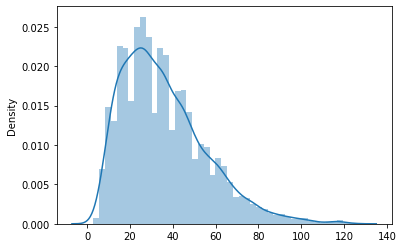

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


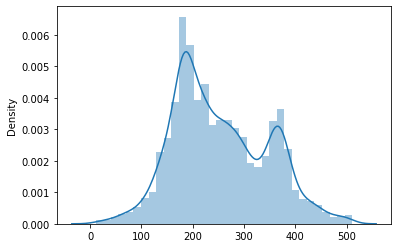

In [ ]:
df = df[(df['good_advice_length'] < 128) & (df['answer_length'] < 512)].reset_index(drop=True)

# Visualize input data
sns.distplot(df["good_advice_length"].to_list())
plt.show()
sns.distplot(df["answer_length"].to_list())
plt.show()

df = df[["답변", "좋은점"]]

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.1)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Convert DataFrame to transformers DatasetDict
train_dataset = datasets.Dataset.from_pandas(train_df)
test_dataset = datasets.Dataset.from_pandas(test_df)
dataset = datasets.DatasetDict({"train":train_dataset,"test":test_dataset})

#### Tokenize answer

In [ ]:
def tokenize_answer(data):
    data = tokenizer(data["답변"], padding="max_length", max_length=512, truncation=False)
    return data

In [ ]:
tokenized_dataset = dataset.map(tokenize_answer, num_proc=5, remove_columns=["답변"])

#0:   0%|          | 0/1242 [00:00<?, ?ex/s]

#1:   0%|          | 0/1241 [00:00<?, ?ex/s]

#2:   0%|          | 0/1241 [00:00<?, ?ex/s]

#3:   0%|          | 0/1241 [00:00<?, ?ex/s]

#4:   0%|          | 0/1241 [00:00<?, ?ex/s]

#0:   0%|          | 0/138 [00:00<?, ?ex/s]

#1:   0%|          | 0/138 [00:00<?, ?ex/s]

#2:   0%|          | 0/138 [00:00<?, ?ex/s]

#3:   0%|          | 0/138 [00:00<?, ?ex/s]

#4:   0%|          | 0/138 [00:00<?, ?ex/s]

#### Tokenize good advice

In [ ]:
def tokenize_good_advice(data):
    data['labels'] = tokenizer.encode(data["좋은점"], padding="max_length", max_length=128, truncation=False)
    return data

In [ ]:
tokenized_dataset = tokenized_dataset.map(tokenize_good_advice, num_proc=5, remove_columns=["좋은점"])

#0:   0%|          | 0/1242 [00:00<?, ?ex/s]

#1:   0%|          | 0/1241 [00:00<?, ?ex/s]

#2:   0%|          | 0/1241 [00:00<?, ?ex/s]

#3:   0%|          | 0/1241 [00:00<?, ?ex/s]

#4:   0%|          | 0/1241 [00:00<?, ?ex/s]

#0:   0%|          | 0/138 [00:00<?, ?ex/s]

#1:   0%|          | 0/138 [00:00<?, ?ex/s]

#2:   0%|          | 0/138 [00:00<?, ?ex/s]

#4:   0%|          | 0/138 [00:00<?, ?ex/s]

#3:   0%|          | 0/138 [00:00<?, ?ex/s]

In [ ]:
tokenized_dataset = tokenized_dataset.remove_columns("token_type_ids")

### Fine tuning - BART

#### Load koBART

In [ ]:
from transformers import BartForConditionalGeneration
model = BartForConditionalGeneration.from_pretrained("gogamza/kobart-base-v2")

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--gogamza--kobart-base-v2/snapshots/d9a1f640896cef8dcfd693b1bc57510a2b09a18f/config.json
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
Model config BartConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartModel"
  ],
  "attention_dropout": 0.0,
  "author": "Heewon Jeon(madjakarta@gmail.com)",
  "bos_token_id": 1,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.1,
  "d_model": 768,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 1,
  "do_blenderbot_90_layernorm": false,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,

#### Set Arguments

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="test_trainer",
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=3, # number of training epochs
    per_device_train_batch_size=8, # batch size for training
    per_device_eval_batch_size=8,  # batch size for evaluation
    save_strategy="epoch",
    evaluation_strategy = "epoch",
    learning_rate=5e-5,
    warmup_steps=500, # number of warmup steps for learning rate scheduler
    weight_decay=0.01, # Weight Regularization
    save_steps=1000, # steps model is saved 
    load_best_model_at_end=True,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"]
)

#### Training

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 6206
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2328


Epoch,Training Loss,Validation Loss
1,2.853600,0.874768
2,0.784200,0.824975
3,0.690400,0.822805


***** Running Evaluation *****
  Num examples = 690
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-776
Configuration saved in test_trainer/checkpoint-776/config.json
Model weights saved in test_trainer/checkpoint-776/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 690
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-1552
Configuration saved in test_trainer/checkpoint-1552/config.json
Model weights saved in test_trainer/checkpoint-1552/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 690
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-2328
Configuration saved in test_trainer/checkpoint-2328/config.json
Model weights saved in test_trainer/checkpoint-2328/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from test_trainer/checkpoint-2328 (score: 0.8228051066398621).


TrainOutput(global_step=2328, training_loss=1.2085973077623295, metrics={'train_runtime': 1500.3409, 'train_samples_per_second': 12.409, 'train_steps_per_second': 1.552, 'total_flos': 5676036689756160.0, 'train_loss': 1.2085973077623295, 'epoch': 3.0})